# Hands-on RL with Ray’s RLlib
## A beginner’s tutorial for working with multi-agent environments, models, and algorithms

### Overview
“Hands-on RL with Ray’s RLlib” is a beginners tutorial for working with reinforcement learning (RL) environments, models, and algorithms using Ray’s RLlib library. RLlib offers high scalability, a large list of algos to choose from (offline, model-based, model-free, etc..), support for TensorFlow and PyTorch, and a unified API for a variety of applications. This tutorial includes a brief introduction to provide an overview of concepts (e.g. why RL) before proceeding to RLlib (multi- and single-agent) environments, neural network models, hyperparameter tuning, debugging, student exercises, Q/A, and more. All code will be provided as .py files in a GitHub repo.

### Intended Audience
* Python programmers who want to get started with reinforcement learning and RLlib.

### Prerequisites
* Some Python programming experience.
* Some familiarity with machine learning.
* *Helpful, but not required:* Experience in reinforcement learning and Ray.
* *Helpful, but not required:* Experience with TensorFlow or PyTorch.

### Requirements/Dependencies

Install conda (https://www.anaconda.com/products/individual)

Then ...

#### Quick `conda` setup instructions (Mac and Linux):
```
$ conda create -n rllib python=3.8
$ conda activate rllib
$ pip install ray[rllib]
$ pip install [tensorflow|torch]  # <- either one works!
$ pip install jupyter-labs
```

#### Quick `conda` setup instructions (Win10):
```
$ conda create -n rllib python=3.8
$ conda activate rllib
$ pip install ray[rllib]
$ pip install [tensorflow|torch]  # <- either one works!
$ pip install jupyter-labs
$ conda install pywin32
```

Also, for Win10 Atari support, we have to install atari_py from a different source (gym does not support Atari envs on Windows).

```
$ pip install git+https://github.com/Kojoley/atari-py.git
```

### Opening these tutorial files:
```
$ git clone https://github.com/sven1977/rllib_tutorials
$ cd rllib_tutorials
$ jupyter-lab
```

### Key Takeaways
* What is reinforcement learning and why RLlib?
* Core concepts of RLlib: Environments, Trainers, Policies, and Models.
* How to configure, hyperparameter-tune, and parallelize RLlib.
* RLlib debugging best practices.

### Tutorial Outline
1. RL and RLlib in a nutshell.
1. Defining an RL-solvable problem: Our first environment.
1. Exercise No.1 (env loop)
1. Picking an algorithm and training our first RLlib Trainer.
1. Configurations and hyperparameters - Easy tuning with Ray Tune.
1. Fixing our experiment's config - Going multi-agent.
1. The "infinite laptop": Quick intro into how to use RLlib with Anyscale's product.
1. Exercise No.2 (run your own Ray RLlib+Tune experiment)
1. Neural network models - Provide your custom models using tf.keras or torch.nn.
1. Deeper dive into RLlib's parallelization architecture.
1. Specifying different compute resources and parallelization options through our config.
1. "Hacking in": Using callbacks to customize the RL loop and generate our own metrics.
1. Exercise No.3 (write your own custom callback)
1. "Hacking in (part II)" - Debugging with RLlib and PyCharm.
1. Checking on the "infinite laptop" - Did RLlib learn to solve the problem?

### Other Recommended Readings
* [Attention Nets and More with RLlib's Trajectory View API](https://medium.com/distributed-computing-with-ray/attention-nets-and-more-with-rllibs-trajectory-view-api-d326339a6e65)
* [Intro to RLlib: Example Environments](https://medium.com/distributed-computing-with-ray/intro-to-rllib-example-environments-3a113f532c70)
* [Reinforcement Learning with RLlib in the Unity Game Engine](https://medium.com/distributed-computing-with-ray/reinforcement-learning-with-rllib-in-the-unity-game-engine-1a98080a7c0d)


In [1]:
import numpy as np

import ray

# Start a new instance of Ray or connect to an already running one.
ray.init()
# In case you encounter this error during our tutorial:
# RuntimeError: Maybe you called ray.init twice by accident?
# Try: ray.shutdown() or ray.init(ignore_reinit_error=True)

d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(
2021-04-29 13:49:50,846	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.2.107',
 'raylet_ip_address': '192.168.2.107',
 'redis_address': '192.168.2.107:6379',
 'object_store_address': 'tcp://127.0.0.1:63568',
 'raylet_socket_name': 'tcp://127.0.0.1:59762',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\svenm\\AppData\\Local\\Temp\\ray\\session_2021-04-29_13-49-45_128347_16184',
 'metrics_export_port': 56979,
 'node_id': '276eb6b965597fe2f73aeb2599d62719d3a8058824b307972a610ac1'}

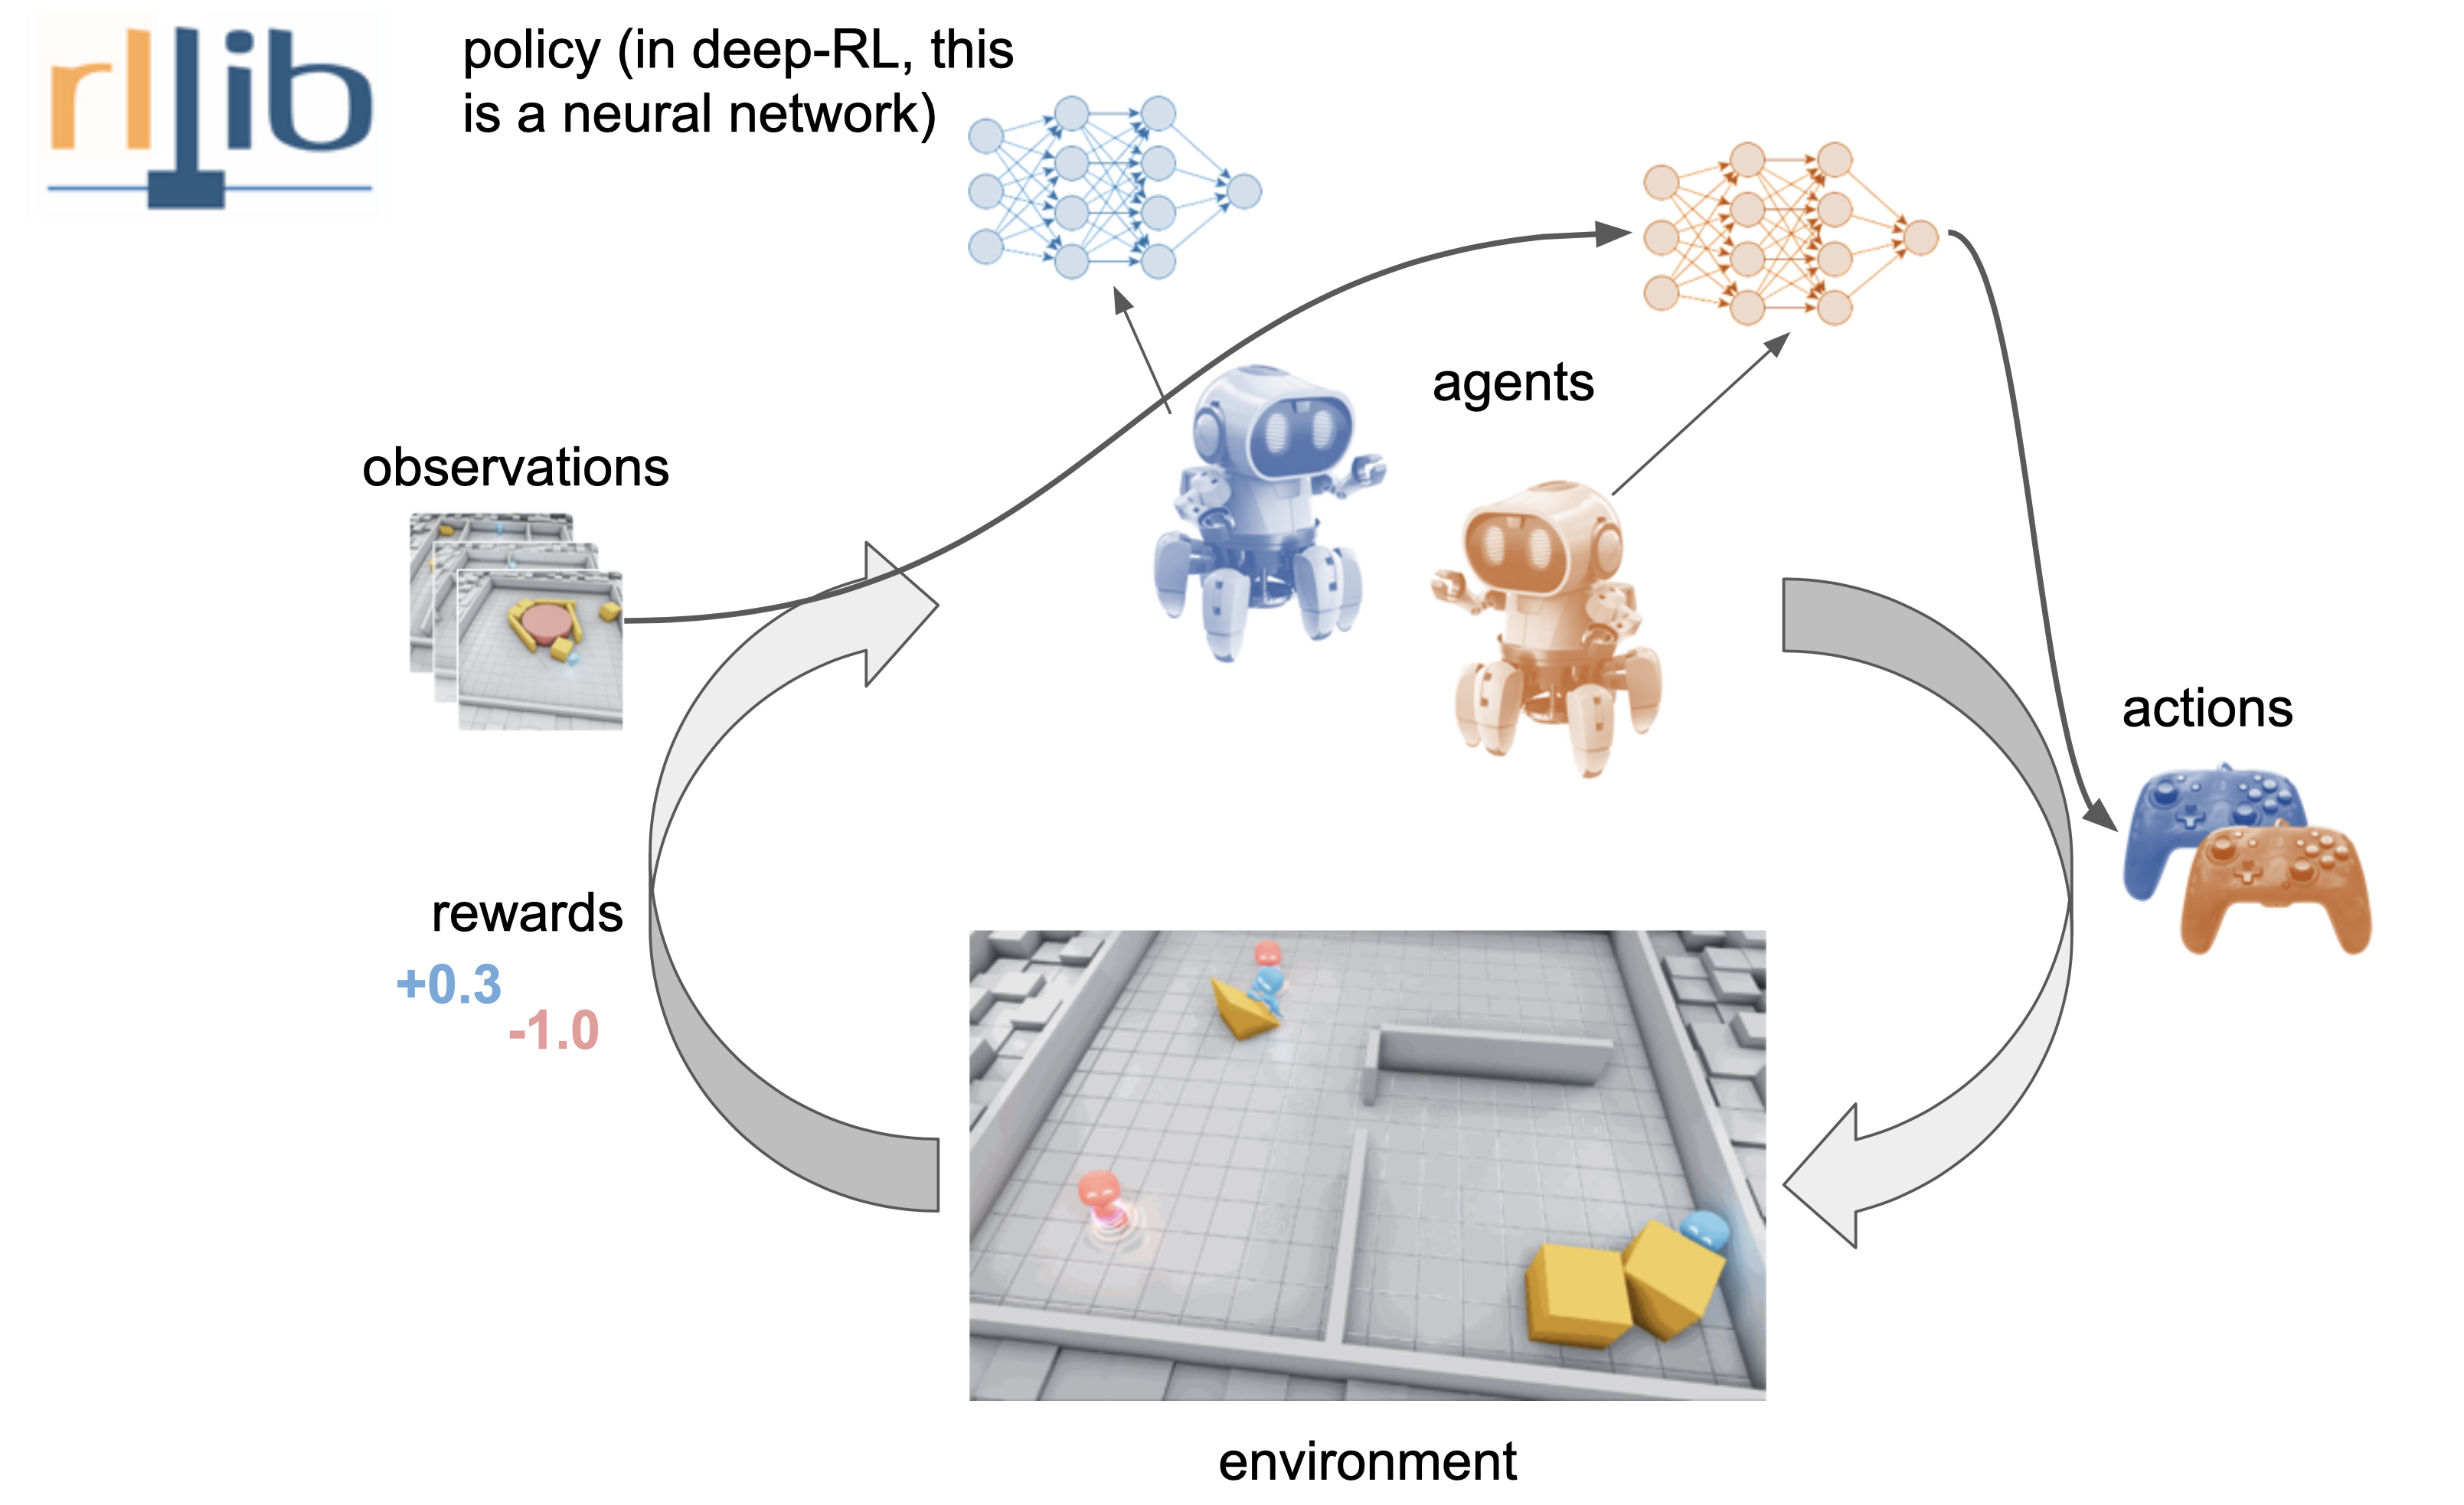

In [2]:
# 2) Coding/defining our "problem" via an RL environment.
# We will use the following (adversarial) multi-agent environment
# throughout this tutorial to demonstrate a large fraction of RLlib's
# APIs, features, and customization options.

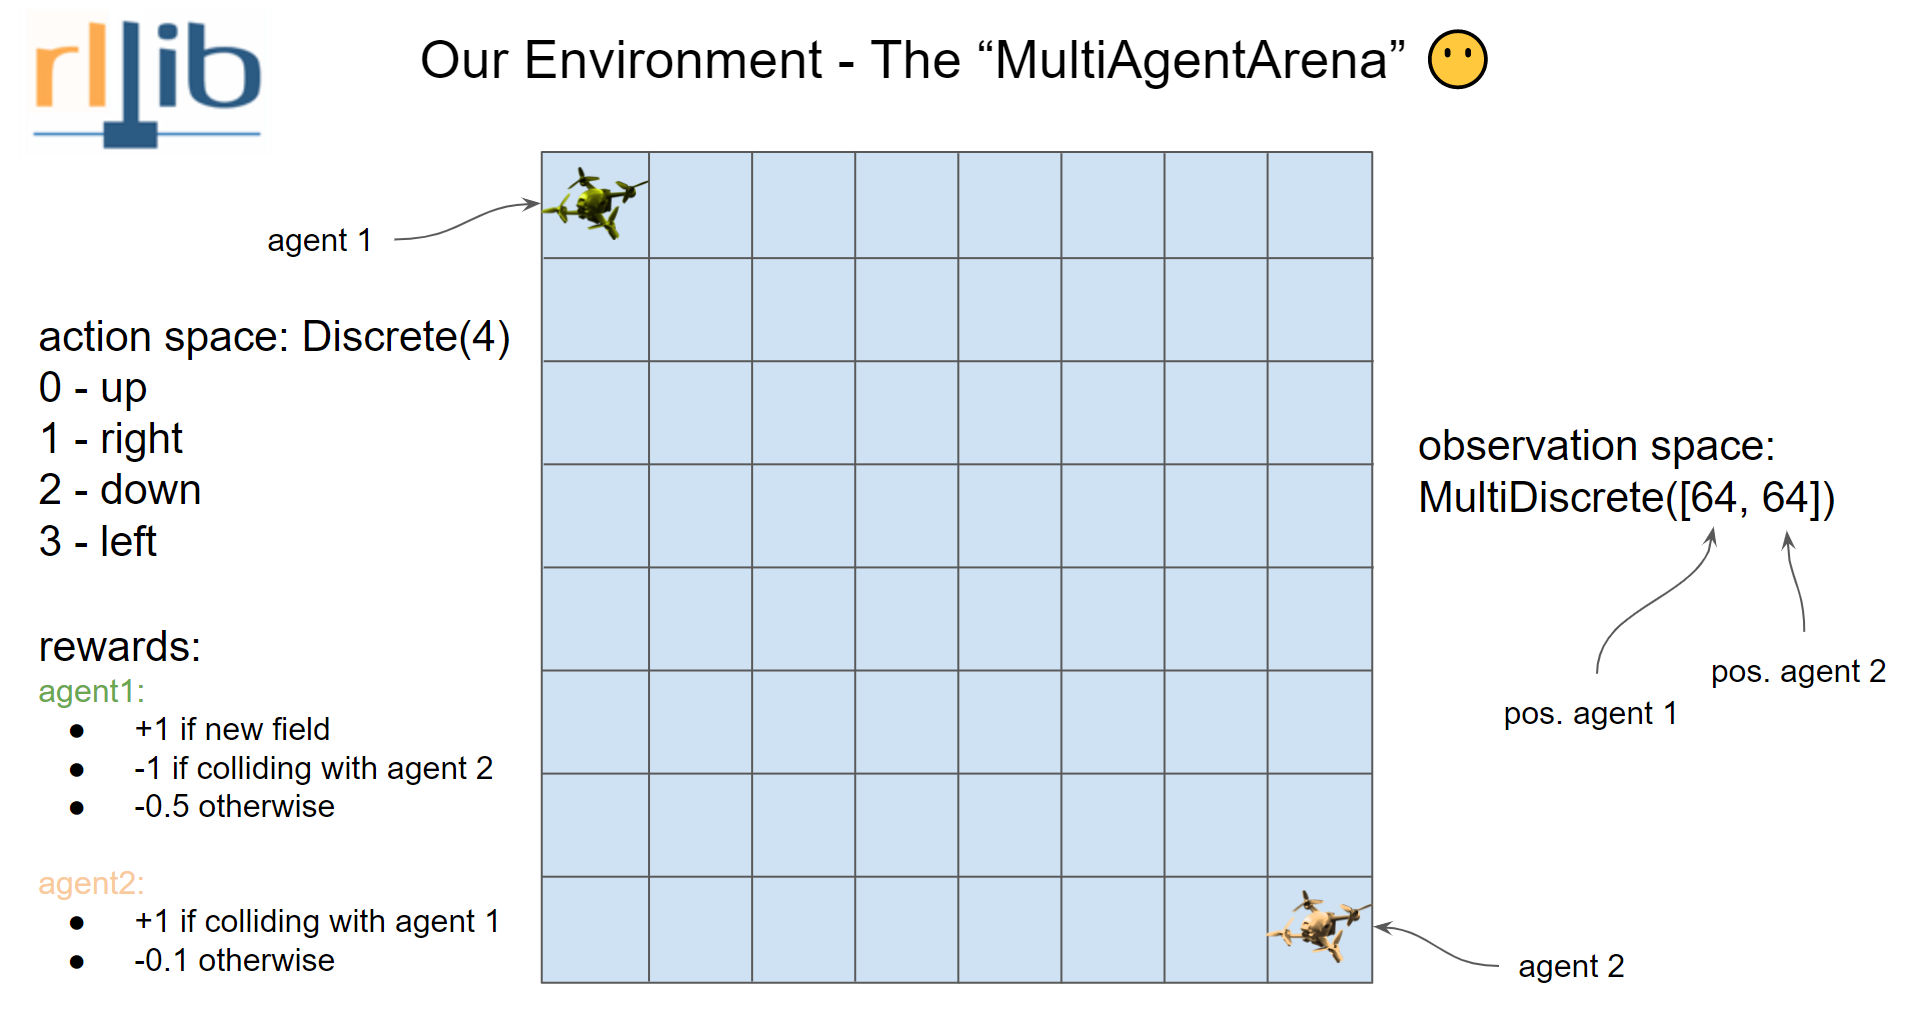

### A word or two on Spaces:

Spaces are used in ML to describe what possible/valid values inputs and outputs of a neural network can have.

RL environments also use them to describe what their valid observations and actions are.

Spaces are usually defined by their shape (e.g. 84x84x3 RGB images) and datatype (e.g. uint8 for RGB values between 0 and 255).
However, spaces could also be composed of other spaces (see Tuple or Dict spaces) or could be simply discrete with n fixed possible values
(represented by integers). For example, in our game, where each agent can only go up/down/left/right, the action space would be "Discrete(4)"
(no datatype, no shape needs to be defined here).

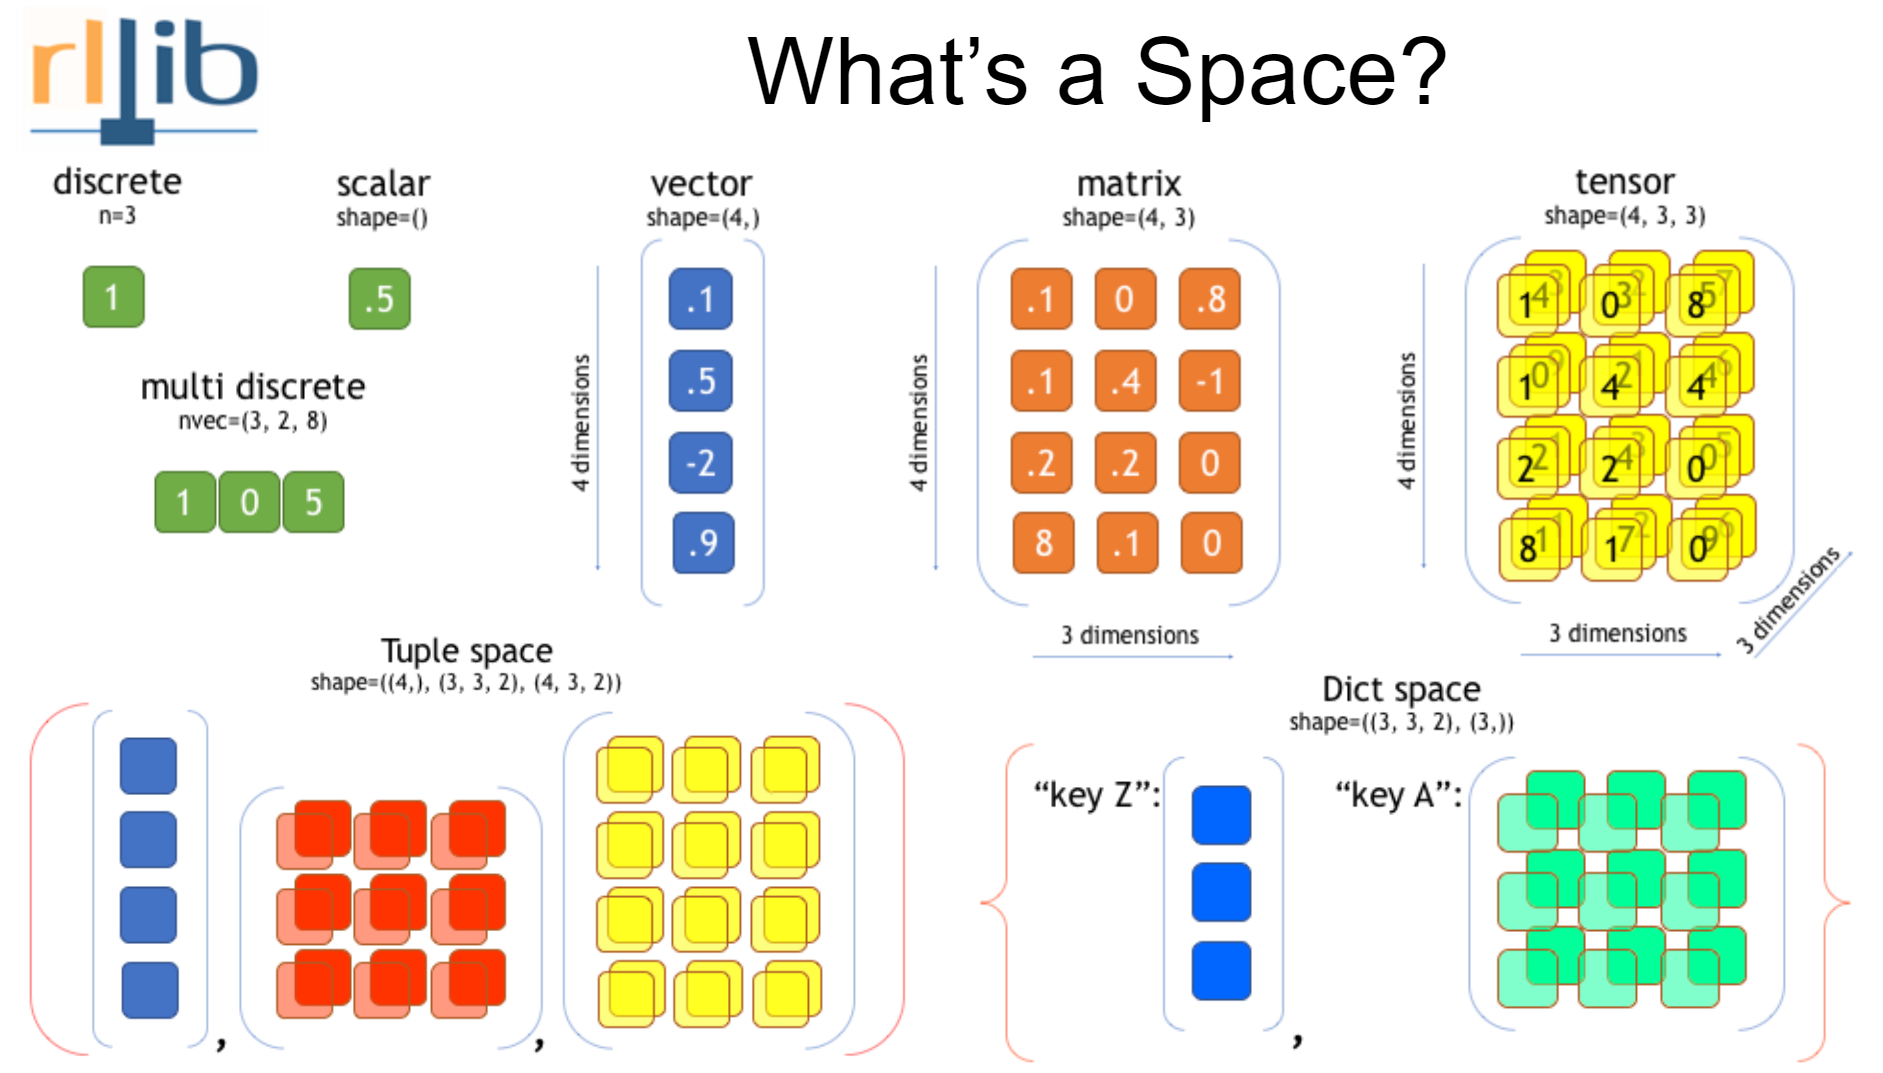

In [12]:
import gym
from gym.spaces import Discrete, MultiDiscrete
import random

from ray.rllib.env.multi_agent_env import MultiAgentEnv

class MultiAgentArena(MultiAgentEnv):
    def __init__(self, config=None):
        # !LIVE CODING!
        config = config or {}
        self.width = config.get("width", 10)
        self.height = config.get("height", 10)

        # 0=up, 1=right, 2=down, 3=left.
        self.action_space = Discrete(4)
        self.observation_space = MultiDiscrete([self.width * self.height,
                                                self.width * self.height])
        # End an episode after this many timesteps.
        self.timestep_limit = config.get("ts", 100)
        # Reset env.
        self.reset()

    def reset(self):
        # !LIVE CODING!
        # Row-major coords.
        self.agent1_pos = [0, 0]
        self.agent2_pos = [self.height - 1, self.width - 1]
        # Reset agent1's visited states.
        self.agent1_visited_states = set()
        # How many timesteps have we done in this episode.
        self.timesteps = 0

        return self.get_obs()

    def step(self, action: dict):
        # !LIVE CODING!
        self.timesteps += 1
        # Determine, who is allowed to move first.
        agent1_first = random.random() > 0.5
        # Move first agent (could be agent 1 or 2).
        if agent1_first:
            r1, r2 = self.move(self.agent1_pos, action["agent1"], is_agent1=True)
            add = self.move(self.agent2_pos, action["agent2"], is_agent1=False)
        else:
            r1, r2 = self.move(self.agent2_pos, action["agent2"], is_agent1=False)
            add = self.move(self.agent1_pos, action["agent1"], is_agent1=True)
        r1 += add[0]
        r2 += add[1]

        obs = self.get_obs()

        reward = {"agent1": r1, "agent2": r2}

        done = self.timesteps >= self.timestep_limit
        done = {"agent1": done, "agent2": done, "__all__": done}

        return obs, reward, done, {}

    def get_obs(self):
        ag1_discrete_pos = self.agent1_pos[0] * self.width + \
            (self.agent1_pos[1] % self.width)
        ag2_discrete_pos = self.agent2_pos[0] * self.width + \
            (self.agent2_pos[1] % self.width)
        return {
            "agent1": np.array([ag1_discrete_pos, ag2_discrete_pos]),
            "agent2": np.array([ag2_discrete_pos, ag1_discrete_pos]),
        }

    def move(self, coords, action, is_agent1):
        orig_coords = coords[:]
        # Change the row: 0=up (-1), 2=down (+1)
        coords[0] += -1 if action == 0 else 1 if action == 2 else 0
        # Change the column: 1=right (+1), 3=left (-1)
        coords[1] += 1 if action == 1 else -1 if action == 3 else 0

        # Solve collisions.
        # Make sure, we don't end up on the other agent's position.
        # If yes, don't move (we are blocked).
        if (is_agent1 and coords == self.agent2_pos) or (not is_agent1 and coords == self.agent1_pos):
            coords[0], coords[1] = orig_coords
            # Agent2 blocked agent1 (agent1 tried to run into agent2)
            # OR Agent2 bumped into agent1 (agent2 tried to run into agent1)
            # -> +1 for agent2; -1 for agent1
            return -1.0, 1.0

        # No agent blocking -> check walls.
        if coords[0] < 0:
            coords[0] = 0
        elif coords[0] >= self.height:
            coords[0] = self.height - 1
        if coords[1] < 0:
            coords[1] = 0
        elif coords[1] >= self.width:
            coords[1] = self.width - 1

        # If agent1 -> +1.0 if new tile covered.
        if is_agent1 and not tuple(coords) in self.agent1_visited_states:
            self.agent1_visited_states.add(tuple(coords))
            return 1.0, -0.1
        # No new tile for agent1 -> Negative reward.
        return -0.5, -0.1

    # Optionally: Add `render` method returning some img.
    def render(self, mode=None):
        return np.random.randint(0, 256, (20, 20, 3), dtype=np.uint8)

## Exercise No 1

Write an "environment loop" using our `MultiAgentArena` class.

1. Create an env object.
1. `reset` your environment to get the first (initial) observation.
1. `step` through the environment using a provided
   "DummyTrainer.compute_action([obs])" method to compute action dicts (see cell below, in which you can create a DummyTrainer object and query it for random actions).
1. When an episode is done, remember to `reset()` your environment before the next call to `step()`.
1. If you feel, this is way too easy for you ;) , try to extract each agent's reward, sum it up over one episode and - at the end of an episode (when done=True) - print out each agent's accumulated reward (also called "return").

**Good luck! :)**


In [18]:
class DummyTrainer:
    """Dummy Trainer class used in Exercise #1.

    Use its `compute_action` method to get a new action, given some environment
    observation.
    """

    def compute_action(self, obs):
        # Returns a random action.
        return {
            "agent1": np.random.randint(4),
            "agent2": np.random.randint(4)
        }

dummy_trainer = DummyTrainer()
# Check, whether it's working.
for _ in range(3):
    print(dummy_trainer.compute_action({"agent1": np.array([0, 10]), "agent2": np.array([10, 0])}))

{'agent1': 3, 'agent2': 3}
{'agent1': 0, 'agent2': 2}
{'agent1': 0, 'agent2': 2}


In [19]:
# Solution to Exercise #1:
#from gym.envs.classic_control.rendering import SimpleImageViewer
#simple_image_viewer = SimpleImageViewer()

# Solution:
env = MultiAgentArena(config={"width": 10, "height": 10})
obs = env.reset()
# Play through a single episode.
done = {"__all__": False}
return_ag1 = return_ag2 = 0.0
num_episodes = 0
while num_episodes < 10:
    action = dummy_trainer.compute_action(obs)
    obs, rewards, done, _ = env.step(action)
    return_ag1 += rewards["agent1"]
    return_ag2 += rewards["agent2"]    
    if done["__all__"]:
        print(f"Episode done. R1={return_ag1} R2={return_ag2}")
        num_episodes += 1
        return_ag1 = return_ag2 = 0.0
        obs = env.reset()
    # Optional:
    #img = env.render()
    #simple_image_viewer.imshow(img)


Episode done. R1=-40.0 R2=-19.99999999999996
Episode done. R1=-40.0 R2=-13.399999999999983
Episode done. R1=-51.0 R2=-18.899999999999963
Episode done. R1=-31.0 R2=-19.99999999999996
Episode done. R1=-47.5 R2=-19.99999999999996
Episode done. R1=-46.0 R2=-19.99999999999996
Episode done. R1=-46.0 R2=-19.99999999999996
Episode done. R1=-61.0 R2=-19.99999999999996
Episode done. R1=-43.5 R2=-18.899999999999963
Episode done. R1=-38.5 R2=-19.99999999999996


In [20]:
# 4) Plugging in RLlib.

# Import a Trainable (one of RLlib's built-in algorithms):
# We use the PPO algorithm here b/c its very flexible wrt its supported
# action spaces and model types and b/c it learns well almost any problem.
from ray.rllib.agents.ppo import PPOTrainer

# Specify a very simple config, defining our environment and some environment
# options (see environment.py).
config = {
    "env": MultiAgentArena,
    "env_config": {
        "config": {
            "width": 10,
            "height": 10,
        },
    },
    # "framework": "torch",
    "create_env_on_driver": True,
}
# Instantiate the Trainer object using above config.
rllib_trainer = PPOTrainer(config=config)


(pid=5108) WARNING:tensorflow:From d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=5108) Instructions for updating:
(pid=5108) non-resource variables are not supported in the long term
(pid=8528) WARNING:tensorflow:From d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=8528) Instructions for updating:
(pid=8528) non-resource variables are not supported in the long term
2021-04-29 14:16:13,987	WARNING util.py:53 -- Install gputil for GPU system monitoring.


In [21]:
# That's it, we are ready to train.
# Calling `train` once runs a single "training iteration". One iteration
# for most algos contains a) sampling from the environment(s) + b) using the
# sampled data (observations, actions taken, rewards) to update the policy
# model (neural network), such that it would pick better actions in the future,
# leading to higher rewards.
print(rllib_trainer.train())

(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(


{'episode_reward_max': -51.00000000000003, 'episode_reward_min': -84.00000000000011, 'episode_reward_mean': -64.30500000000009, 'episode_len_mean': 100.0, 'episode_media': {}, 'episodes_this_iter': 20, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [-58.500000000000156, -84.00000000000011, -79.50000000000013, -61.50000000000013, -63.000000000000085, -73.5000000000001, -58.50000000000014, -58.50000000000007, -71.70000000000012, -63.90000000000007, -61.50000000000012, -58.80000000000005, -59.40000000000006, -57.00000000000009, -63.90000000000005, -51.00000000000003, -60.90000000000007, -54.000000000000036, -76.50000000000014, -70.5000000000001], 'episode_lengths': [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]}, 'sampler_perf': {'mean_raw_obs_processing_ms': 0.13138126064609218, 'mean_inference_ms': 0.6323618131441312, 'mean_action_processing_ms': 0.05

(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(
(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(
(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=Non

In [25]:
# Run `train()` n times. Try to repeatedly call this to see rewards increase.
# Move on once you see episode rewards > -50.0.
for i in range(10):
    results = rllib_trainer.train()
    print(f"iteration {i}: R={results['episode_reward_mean']}")

iteration 0: R=-54.93900000000005
iteration 1: R=-54.690000000000055
iteration 2: R=-53.63700000000005
iteration 3: R=-52.91400000000006
iteration 4: R=-52.39500000000005


(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(


iteration 5: R=-52.52100000000005
iteration 6: R=-52.08900000000005
iteration 7: R=-51.64800000000005
iteration 8: R=-50.55900000000004
iteration 9: R=-50.535000000000046


(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(
(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(
(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=Non

In [26]:
# !LIVE CODING!
# Let's actually "look inside" our Trainer to see what's in there.
pol = rllib_trainer.get_policy()
print(f"Policy: {pol}; Observation-space: {pol.observation_space}; Action-space: {pol.action_space}")

print(f"Model: {pol.model}")

# Create a fake numpy B=1 (single) observation consisting of both agents positions ("one-hot'd" and "concat'd").
from ray.rllib.utils.numpy import one_hot
single_obs = np.concatenate([one_hot(0, depth=100), one_hot(99, depth=100)])
single_obs = np.array([single_obs])
#single_obs.shape

# Generate the Model's output.
out, state_out = pol.model({"obs": single_obs})

# tf1.x (static graph) -> Need to run this through a tf session.
numpy_out = pol._sess.run(out)

# RLlib then passes the model's output to the policy's "action distribution" to sample an action.
action_dist = pol.dist_class(out)
action = action_dist.sample()

# Show us the actual action.
pol._sess.run(action)

Policy: <ray.rllib.policy.tf_policy_template.PPOTFPolicy object at 0x00000250C0D18730>; Observation-space: Box(-1.0, 1.0, (200,), float32); Action-space: Discrete(4)
Model: <ray.rllib.models.tf.fcnet.FullyConnectedNetwork object at 0x00000250C0D18F10>


array([3], dtype=int64)

In [27]:
# Save our trainer.
checkpoint_path = rllib_trainer.save()
print(f"Trainer was saved in '{checkpoint_path}'!")

import os
os.listdir(os.path.dirname(checkpoint_path))

Trainer was saved in 'C:\Users\svenm/ray_results\PPO_MultiAgentArena_2021-04-29_14-16-09znizwlex\checkpoint_000041\checkpoint-41'!


['.is_checkpoint', 'checkpoint-41', 'checkpoint-41.tune_metadata']

(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(


In [28]:
# Pretend, we wanted to pick up training from a previous run:
new_trainer = PPOTrainer(config=config)
# Evaluate the new trainer (this should yield random results).
results = new_trainer._evaluate()
print(f"Evaluating new trainer: R={results['evaluation']['episode_reward_mean']}")

# Restoring the trained state into the `new_trainer` object.
new_trainer.restore(checkpoint_path)

# Evaluate again (this should yield results we saw after having trained our saved agent).
results = new_trainer._evaluate()
print(f"Evaluating restored trainer: R={results['evaluation']['episode_reward_mean']}")

(pid=9956) WARNING:tensorflow:From d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=9956) Instructions for updating:
(pid=9956) non-resource variables are not supported in the long term
(pid=7840) WARNING:tensorflow:From d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=7840) Instructions for updating:
(pid=7840) non-resource variables are not supported in the long term
2021-04-29 14:31:55,455	WARNING util.py:53 -- Install gputil for GPU system monitoring.


AttributeError: 'PPO' object has no attribute 'evaluation_workers'

In [30]:
# 5) Configuration dicts and Ray Tune.
# Where are the default configuration dicts stored?
import pprint
from ray.rllib.agents.ppo import DEFAULT_CONFIG as PPO_DEFAULT_CONFIG
print(f"PPO's default config is:")
pprint.pprint(PPO_DEFAULT_CONFIG)

#from ray.rllib.agents.dqn import DEFAULT_CONFIG as DQN_DEFAULT_CONFIG
#print(f"DQN's default config is:")
#pprint.pprint(DQN_DEFAULT_CONFIG)

#from ray.rllib.agents.trainer import COMMON_CONFIG
#print(f"RLlib Trainer's default config is:")
#pprint.pprint(COMMON_CONFIG)

PPO's default config is:
{'_fake_gpus': False,
 'batch_mode': 'truncate_episodes',
 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>,
 'clip_actions': True,
 'clip_param': 0.3,
 'clip_rewards': None,
 'collect_metrics_timeout': 180,
 'compress_observations': False,
 'create_env_on_driver': False,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'eager_tracing': False,
 'entropy_coeff': 0.0,
 'entropy_coeff_schedule': None,
 'env': None,
 'env_config': {},
 'evaluation_config': {},
 'evaluation_interval': None,
 'evaluation_num_episodes': 10,
 'evaluation_num_workers': 0,
 'exploration_config': {'type': 'StochasticSampling'},
 'explore': True,
 'extra_python_environs_for_driver': {},
 'extra_python_environs_for_worker': {},
 'fake_sampler': False,
 'framework': 'tf',
 'gamma': 0.99,
 'grad_clip': None,
 'horizon': None,
 'ignore_worker_failures': False,
 'in_evaluation': False,
 'input': 'sampler',
 'input_evaluation': ['is', 'wis'],
 'kl_coeff': 0.2

In [31]:
# Plugging in Ray Tune.
# Note that this is the recommended way to run any experiments with RLlib.
# Reasons:
# - Tune allows you to do hyperparameter tuning in a user-friendly way
#   and at large scale!
# - Tune automatically allocates needed resources for the different
#   hyperparam trials and experiment runs.

from ray import tune

# Now that we will run things "automatically" through tune, we have to
# define one or more stopping criteria.
stop = {
    # explain that keys here can be anything present in the above print(trainer.train())
    "training_iteration": 5,
    "episode_reward_mean": 9999.9,
}

# "PPO" is a registered name that points to RLlib's PPOTrainer.
# See `ray/rllib/agents/registry.py`
# Run our simple experiment until one of the stop criteria is met.
tune.run("PPO", config=config, stop=stop)


Trial name,status,loc
PPO_MultiAgentArena_eeefa_00000,PENDING,


(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(
(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(
2021-04-29 14:32:21,663	ERROR syncer.py:72 -- Log sync requires rsync to be installed.
(pid=11136) WARNING:tensorflow:From d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will 

Result for PPO_MultiAgentArena_eeefa_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-04-29_14-32-36
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -44.100000000000016
  episode_reward_mean: -65.2050000000001
  episode_reward_min: -85.50000000000017
  episodes_this_iter: 20
  episodes_total: 20
  experiment_id: a11c37784a1f4b8aa1b5876b822de9c8
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 1.3637638092041016
          entropy_coeff: 0.0
          kl: 0.023099780082702637
          model: {}
          policy_loss: -0.05356709286570549
          total_loss: 107.17808532714844
          vf_explained_var: 0.05352780222892761
          vf_loss: 107.22702026367188
    num_agent_steps_sampled: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_eeefa_00000,RUNNING,192.168.2.107:11136,1,2.76517,4000,-65.205,-44.1,-85.5,100


Result for PPO_MultiAgentArena_eeefa_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-04-29_14-32-41
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -42.90000000000001
  episode_reward_mean: -65.8350000000001
  episode_reward_min: -96.00000000000014
  episodes_this_iter: 20
  episodes_total: 60
  experiment_id: a11c37784a1f4b8aa1b5876b822de9c8
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 1.3006224632263184
          entropy_coeff: 0.0
          kl: 0.01894197426736355
          model: {}
          policy_loss: -0.05772906541824341
          total_loss: 67.49411010742188
          vf_explained_var: 0.369282066822052
          vf_loss: 67.54615783691406
    num_agent_steps_sampled: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_since_restore: 3
  node_i

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_eeefa_00000,RUNNING,192.168.2.107:11136,3,7.7958,12000,-65.835,-42.9,-96,100


Result for PPO_MultiAgentArena_eeefa_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-04-29_14-32-47
  done: true
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -38.70000000000001
  episode_reward_mean: -63.591000000000086
  episode_reward_min: -96.00000000000014
  episodes_this_iter: 20
  episodes_total: 100
  experiment_id: a11c37784a1f4b8aa1b5876b822de9c8
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 1.248320460319519
          entropy_coeff: 0.0
          kl: 0.019219577312469482
          model: {}
          policy_loss: -0.0509619377553463
          total_loss: 67.10884857177734
          vf_explained_var: 0.2370084971189499
          vf_loss: 67.15404510498047
    num_agent_steps_sampled: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
  iterations_since_restore: 5
  node

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_eeefa_00000,TERMINATED,,5,13.1058,20000,-63.591,-38.7,-96,100


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_eeefa_00000,TERMINATED,,5,13.1058,20000,-63.591,-38.7,-96,100


(pid=10872) Windows fatal exception: access violation
(pid=10872) 
(pid=13472) Windows fatal exception: access violation
(pid=13472) 
2021-04-29 14:32:47,707	INFO tune.py:549 -- Total run time: 30.76 seconds (30.37 seconds for the tuning loop).
(pid=11136) Windows fatal exception: access violation
(pid=11136) 
(pid=11136) Stack (most recent call first):
(pid=11136)   File "d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\worker.py", line 382 in main_loop
(pid=11136)   File "d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\workers/default_worker.py", line 196 in <module>


(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(


In [32]:
# Updating an algo's default config dict and adding hyperparameter tuning
# options to it.
# Note: Hyperparameter tuning options (e.g. grid_search) will only work,
# if we run these configs via `tune.run`.
config.update(
    {
        # Try 2 different learning rates.
        "lr": tune.grid_search([0.0001, 0.5]),
        # NN model config to tweak the default model
        # that'll be created by RLlib for the policy.
        "model": {
            # e.g. change the dense layer stack.
            "fcnet_hiddens": [256, 256, 256],
            # Alternatively, you can specify a custom model here
            # (we'll cover that later).
            # "custom_model": ...
            # Pass kwargs to your custom model.
            # "custom_model_config": {}
        },
    }
)
# Repeat our experiment using tune's grid-search feature.
results = tune.run(
    "PPO",
    config=config,
    stop=stop,
    checkpoint_at_end=True,  # create a checkpoint when done.
    checkpoint_freq=1,  # create a checkpoint on every iteration.
)
print(results)


Trial name,status,loc,lr
PPO_MultiAgentArena_0b6d7_00000,RUNNING,,0.0001
PPO_MultiAgentArena_0b6d7_00001,PENDING,,0.5


(pid=2540) WARNING:tensorflow:From d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=2540) Instructions for updating:
(pid=2540) non-resource variables are not supported in the long term
(pid=2540) 2021-04-29 14:33:07,797	INFO trainer.py:669 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=2540) 2021-04-29 14:33:07,799	INFO trainer.py:694 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None

Trial name,status,loc,lr
PPO_MultiAgentArena_0b6d7_00000,RUNNING,,0.0001
PPO_MultiAgentArena_0b6d7_00001,PENDING,,0.5


(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(
(pid=4568) WARNING:tensorflow:From d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=4568) Instructions for updating:
(pid=4568) non-resource variables are not supported in the long term
(pid=13252) WARNING:tensorflow:From d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=13252) Instructions

Result for PPO_MultiAgentArena_0b6d7_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-04-29_14-33-21
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -44.400000000000034
  episode_reward_mean: -74.02500000000012
  episode_reward_min: -87.00000000000017
  episodes_this_iter: 20
  episodes_total: 20
  experiment_id: 3719d98c54fa446597b9cc85f677858e
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 9.999999747378752e-05
          entropy: 1.346617341041565
          entropy_coeff: 0.0
          kl: 0.0405283197760582
          model: {}
          policy_loss: -0.07589749991893768
          total_loss: 157.8623809814453
          vf_explained_var: 0.13389801979064941
          vf_loss: 157.93017578125
    num_agent_steps_sampled: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 1

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_0b6d7_00000,RUNNING,192.168.2.107:2540,0.0001,1,3.71347,4000,-74.025,-44.4,-87,100
PPO_MultiAgentArena_0b6d7_00001,PENDING,,0.5,,,,,,,


(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(


Result for PPO_MultiAgentArena_0b6d7_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-04-29_14-33-28
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -35.100000000000016
  episode_reward_mean: -67.48000000000009
  episode_reward_min: -94.50000000000013
  episodes_this_iter: 20
  episodes_total: 60
  experiment_id: 3719d98c54fa446597b9cc85f677858e
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.44999998807907104
          cur_lr: 9.999999747378752e-05
          entropy: 1.277524471282959
          entropy_coeff: 0.0
          kl: 0.02869405224919319
          model: {}
          policy_loss: -0.0678851529955864
          total_loss: 65.19987487792969
          vf_explained_var: 0.42221689224243164
          vf_loss: 65.25484466552734
    num_agent_steps_sampled: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_since_restore: 3
  node

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_0b6d7_00000,RUNNING,192.168.2.107:2540,0.0001,3,10.6455,12000,-67.48,-35.1,-94.5,100
PPO_MultiAgentArena_0b6d7_00001,PENDING,,0.5,,,,,,,


Result for PPO_MultiAgentArena_0b6d7_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-04-29_14-33-35
  done: true
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -35.100000000000016
  episode_reward_mean: -65.2410000000001
  episode_reward_min: -94.50000000000013
  episodes_this_iter: 20
  episodes_total: 100
  experiment_id: 3719d98c54fa446597b9cc85f677858e
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 9.999999747378752e-05
          entropy: 1.2355352640151978
          entropy_coeff: 0.0
          kl: 0.018556885421276093
          model: {}
          policy_loss: -0.06662617623806
          total_loss: 54.341766357421875
          vf_explained_var: 0.36645716428756714
          vf_loss: 54.38960266113281
    num_agent_steps_sampled: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
  iterations_since_restore: 5
  node_

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_0b6d7_00000,RUNNING,192.168.2.107:2540,0.0001,5,17.7615,20000,-65.241,-35.1,-94.5,100
PPO_MultiAgentArena_0b6d7_00001,PENDING,,0.5,,,,,,,


(pid=8244) WARNING:tensorflow:From d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=8244) Instructions for updating:
(pid=8244) non-resource variables are not supported in the long term
(pid=8244) 2021-04-29 14:33:39,289	INFO trainer.py:669 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=8244) 2021-04-29 14:33:39,290	INFO trainer.py:694 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None

Result for PPO_MultiAgentArena_0b6d7_00001:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-04-29_14-33-53
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -51.600000000000044
  episode_reward_mean: -68.53500000000011
  episode_reward_min: -90.00000000000014
  episodes_this_iter: 20
  episodes_total: 20
  experiment_id: f7bc4db180234dbc8df65dddf200f4b8
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 0.5
          entropy: 0.09127754718065262
          entropy_coeff: 0.0
          kl: 30.77556037902832
          model: {}
          policy_loss: 0.4832269251346588
          total_loss: 205.0349884033203
          vf_explained_var: -0.33130910992622375
          vf_loss: 198.39663696289062
    num_agent_steps_sampled: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 192.168.2.107
  

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_0b6d7_00001,RUNNING,192.168.2.107:8244,0.5,1,3.72201,4000,-68.535,-51.6,-90,100
PPO_MultiAgentArena_0b6d7_00000,TERMINATED,,0.0001,5,17.7615,20000,-65.241,-35.1,-94.5,100


Result for PPO_MultiAgentArena_0b6d7_00001:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-04-29_14-34-00
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -51.600000000000044
  episode_reward_mean: -93.84500000000016
  episode_reward_min: -106.50000000000017
  episodes_this_iter: 20
  episodes_total: 60
  experiment_id: f7bc4db180234dbc8df65dddf200f4b8
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.15000000596046448
          cur_lr: 0.5
          entropy: 0.0
          entropy_coeff: 0.0
          kl: 0.0
          model: {}
          policy_loss: 0.00556423794478178
          total_loss: 204.7751007080078
          vf_explained_var: 0.6013797521591187
          vf_loss: 204.76953125
    num_agent_steps_sampled: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_since_restore: 3
  node_ip: 192.168.2.107
  num_healthy_workers: 2
  off_pol

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_0b6d7_00001,RUNNING,192.168.2.107:8244,0.5,3,10.53,12000,-93.845,-51.6,-106.5,100
PPO_MultiAgentArena_0b6d7_00000,TERMINATED,,0.0001,5,17.7615,20000,-65.241,-35.1,-94.5,100


Result for PPO_MultiAgentArena_0b6d7_00001:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-04-29_14-34-07
  done: true
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -51.600000000000044
  episode_reward_mean: -98.90700000000017
  episode_reward_min: -106.50000000000017
  episodes_this_iter: 20
  episodes_total: 100
  experiment_id: f7bc4db180234dbc8df65dddf200f4b8
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.03750000149011612
          cur_lr: 0.5
          entropy: 0.0
          entropy_coeff: 0.0
          kl: 0.0
          model: {}
          policy_loss: 0.006155822426080704
          total_loss: 162.8755340576172
          vf_explained_var: 0.6077548861503601
          vf_loss: 162.869384765625
    num_agent_steps_sampled: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
  iterations_since_restore: 5
  node_ip: 192.168.2.107
  num_healthy_workers: 2
  of

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_0b6d7_00001,RUNNING,192.168.2.107:8244,0.5,5,17.657,20000,-98.907,-51.6,-106.5,100
PPO_MultiAgentArena_0b6d7_00000,TERMINATED,,0.0001,5,17.7615,20000,-65.241,-35.1,-94.5,100


Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_0b6d7_00000,TERMINATED,,0.0001,5,17.7615,20000,-65.241,-35.1,-94.5,100
PPO_MultiAgentArena_0b6d7_00001,TERMINATED,,0.5,5,17.657,20000,-98.907,-51.6,-106.5,100


(pid=8244) Windows fatal exception: access violation
(pid=8244) 
(pid=8244) Stack (most recent call first):
(pid=8244)   File "d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\worker.py", line 382 in main_loop
(pid=8244)   File "d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\workers/default_worker.py", line 196 in <module>
(pid=9432) Windows fatal exception: access violation
(pid=9432) 
(pid=3656) Windows fatal exception: access violation
(pid=3656) 
(pid=3656) Stack (most recent call first):
(pid=3656)   File "d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\worker.py", line 382 in main_loop
(pid=3656)   File "d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\workers/default_worker.py", line 196 in <module>
2021-04-29 14:34:08,084	INFO tune.py:549 -- Total run time: 63.33 seconds (62.75 seconds for the tuning loop).


(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(
(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(
(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=Non

In [33]:
# 6) Going multi-policy: Our experiment is ill-configured b/c both
# agents, which should behave differently due to their different
# tasks and reward functions, learn the same policy (the "default_policy",
# which RLlib always provides if you don't configure anything else; Remember
# that RLlib does not know at Trainer setup time, how many and which agents
# the environment will "produce").
# Let's fix this and introduce the "multiagent" API.

# 6.1.) Define an agent->policy mapping function.
# Which agents (defined by the environment) use which policies
# (defined by us)? Mapping is M (agents) -> N (policies), where M >= N.
def policy_mapping_fn(agent: str):
    assert agent in ["agent1", "agent2"], f"ERROR: invalid agent {agent}!"
    return "pol1" if agent == "agent1" else "pol2"
    
# 6.2.) Define details for our two policies.
#TODO: coding Sven: Make it possible to not need obs/action spaces
#  if they are the default anyways.
observation_space = rllib_trainer.workers.local_worker().env.observation_space
action_space = rllib_trainer.workers.local_worker().env.action_space
# Btw, the above is equivalent to saying:
# >>> rllib_trainer.get_policy("default_policy").obs/action_space
policies = {
    "pol1": (None, observation_space, action_space, {"lr": 0.0003}),
    "pol2": (None, observation_space, action_space, {"lr": 0.0004}),
}

#policies_to_train = ["pol1", "pol2"]

# 6.3) Adding the above to our config.
config.update({
    "multiagent": {
        "policies": policies,
        "policy_mapping_fn": policy_mapping_fn,
        #"policies_to_train": policies_to_train,
    },
})


## Exercise No 2

Try learning our environment using Ray tune.run and a simple hyperparameter grid_search over:
- 2 different learning rates (pick your own values).
- AND 2 different `train_batch_size` settings (use 2000 and 3000).

Also, make RLlib use a [128, 128] dense layer stack as the NN model.

Also, use the config setting of `num_envs_per_worker=10` to increase the sampling throughput.

In case your local machine has less than 12 CPUs, try setting `num_workers=1` to make all tune trials run at the same time.
Background: PPO by default uses 2 workers, which makes 1 trial use 3 CPUs (2 workers + "driver" ("local-worker")),
which makes the entire experiment use 12 CPUs. Tune will run trials in sequence in case it cannot allocate enough CPUs at once
(which is also fine, but then takes longer).

Try to reach a total reward (sum of agent1 and agent2) of -25.0.

**Good luck! :)**


In [ ]:
# Solution to Exercise #2:

# Update our config and set it up for 2x tune grid-searches (leading to 4 parallel trials in total).
config.update({
    "lr": tune.grid_search([0.0001, 0.0005]),
    "train_batch_size": tune.grid_search([2000, 3000]),
    "num_envs_per_worker": 10,
    # Change our model to be simpler.
    "model": {
        "fcnet_hiddens": [128, 128],
    },
})

# Run the experiment.
tune.run("PPO", config=config, stop={"episode_reward_mean": -25.0, "training_iteration": 100})

Trial name,status,loc,lr,train_batch_size
PPO_MultiAgentArena_f0615_00000,RUNNING,,0.0001,2000
PPO_MultiAgentArena_f0615_00001,PENDING,,0.0005,2000
PPO_MultiAgentArena_f0615_00002,PENDING,,0.0001,3000
PPO_MultiAgentArena_f0615_00003,PENDING,,0.0005,3000


(pid=11216) WARNING:tensorflow:From d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=11216) Instructions for updating:
(pid=11216) non-resource variables are not supported in the long term
(pid=11216) 2021-04-29 14:46:41,338	INFO trainer.py:669 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=11216) 2021-04-29 14:46:41,339	INFO trainer.py:694 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid

Trial name,status,loc,lr,train_batch_size
PPO_MultiAgentArena_f0615_00000,RUNNING,,0.0001,2000
PPO_MultiAgentArena_f0615_00001,PENDING,,0.0005,2000
PPO_MultiAgentArena_f0615_00002,PENDING,,0.0001,3000
PPO_MultiAgentArena_f0615_00003,PENDING,,0.0005,3000


(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(
(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(
(pid=2536) WARNING:tensorflow:From d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=2536) Instructions for updating:
(pid=2536) non-res

Result for PPO_MultiAgentArena_f0615_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-04-29_14-46-56
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -39.900000000000006
  episode_reward_mean: -67.38000000000011
  episode_reward_min: -96.00000000000013
  episodes_this_iter: 40
  episodes_total: 40
  experiment_id: aa418a5543bc452c90992af61ec38d13
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      pol1:
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 0.0003000000142492354
          entropy: 1.3489956855773926
          entropy_coeff: 0.0
          kl: 0.03896395489573479
          model: {}
          policy_loss: -0.07424399256706238
          total_loss: 229.30316162109375
          vf_explained_var: 0.034799933433532715
          vf_loss: 229.36961364746094
      pol2:
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 0.00039999998989515007
          entro

Trial name,status,loc,lr,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_f0615_00000,RUNNING,192.168.2.107:11216,0.0001,2000,1,3.51425,4000,-67.38,-39.9,-96,100
PPO_MultiAgentArena_f0615_00001,PENDING,,0.0005,2000,,,,,,,
PPO_MultiAgentArena_f0615_00002,PENDING,,0.0001,3000,,,,,,,
PPO_MultiAgentArena_f0615_00003,PENDING,,0.0005,3000,,,,,,,


Result for PPO_MultiAgentArena_f0615_00000:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2021-04-29_14-47-02
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -38.40000000000005
  episode_reward_mean: -62.646000000000086
  episode_reward_min: -97.50000000000014
  episodes_this_iter: 40
  episodes_total: 120
  experiment_id: aa418a5543bc452c90992af61ec38d13
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      pol1:
        learner_stats:
          cur_kl_coeff: 0.44999998807907104
          cur_lr: 0.0003000000142492354
          entropy: 1.2683017253875732
          entropy_coeff: 0.0
          kl: 0.03104763850569725
          model: {}
          policy_loss: -0.06988108903169632
          total_loss: 67.16598510742188
          vf_explained_var: 0.23781123757362366
          vf_loss: 67.2219009399414
      pol2:
        learner_stats:
          cur_kl_coeff: 0.44999998807907104
          cur_lr: 0.00039999998989515007
          entropy

Trial name,status,loc,lr,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_f0615_00000,RUNNING,192.168.2.107:11216,0.0001,2000,3,9.77027,12000,-62.646,-38.4,-97.5,100
PPO_MultiAgentArena_f0615_00001,PENDING,,0.0005,2000,,,,,,,
PPO_MultiAgentArena_f0615_00002,PENDING,,0.0001,3000,,,,,,,
PPO_MultiAgentArena_f0615_00003,PENDING,,0.0005,3000,,,,,,,


Result for PPO_MultiAgentArena_f0615_00000:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2021-04-29_14-47-09
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -39.60000000000004
  episode_reward_mean: -58.131000000000064
  episode_reward_min: -82.50000000000011
  episodes_this_iter: 40
  episodes_total: 200
  experiment_id: aa418a5543bc452c90992af61ec38d13
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      pol1:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.0003000000142492354
          entropy: 1.2266274690628052
          entropy_coeff: 0.0
          kl: 0.01885942369699478
          model: {}
          policy_loss: -0.0651787742972374
          total_loss: 71.53939819335938
          vf_explained_var: 0.17537793517112732
          vf_loss: 71.58547973632812
      pol2:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.00039999998989515007
          entropy: 

Trial name,status,loc,lr,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_f0615_00000,RUNNING,192.168.2.107:11216,0.0001,2000,5,16.0967,20000,-58.131,-39.6,-82.5,100
PPO_MultiAgentArena_f0615_00001,PENDING,,0.0005,2000,,,,,,,
PPO_MultiAgentArena_f0615_00002,PENDING,,0.0001,3000,,,,,,,
PPO_MultiAgentArena_f0615_00003,PENDING,,0.0005,3000,,,,,,,


Result for PPO_MultiAgentArena_f0615_00000:
  agent_timesteps_total: 56000
  custom_metrics: {}
  date: 2021-04-29_14-47-15
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -35.99999999999999
  episode_reward_mean: -55.77600000000007
  episode_reward_min: -75.30000000000014
  episodes_this_iter: 40
  episodes_total: 280
  experiment_id: aa418a5543bc452c90992af61ec38d13
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      pol1:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.0003000000142492354
          entropy: 1.1976325511932373
          entropy_coeff: 0.0
          kl: 0.017283087596297264
          model: {}
          policy_loss: -0.06329740583896637
          total_loss: 64.95588684082031
          vf_explained_var: 0.176110178232193
          vf_loss: 65.00167846679688
      pol2:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.00039999998989515007
          entropy: 1

Trial name,status,loc,lr,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_f0615_00000,RUNNING,192.168.2.107:11216,0.0001,2000,7,22.2718,28000,-55.776,-36,-75.3,100
PPO_MultiAgentArena_f0615_00001,PENDING,,0.0005,2000,,,,,,,
PPO_MultiAgentArena_f0615_00002,PENDING,,0.0001,3000,,,,,,,
PPO_MultiAgentArena_f0615_00003,PENDING,,0.0005,3000,,,,,,,


(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(


Result for PPO_MultiAgentArena_f0615_00000:
  agent_timesteps_total: 72000
  custom_metrics: {}
  date: 2021-04-29_14-47-21
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -40.50000000000003
  episode_reward_mean: -56.77200000000007
  episode_reward_min: -75.0000000000001
  episodes_this_iter: 40
  episodes_total: 360
  experiment_id: aa418a5543bc452c90992af61ec38d13
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      pol1:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.0003000000142492354
          entropy: 1.1651113033294678
          entropy_coeff: 0.0
          kl: 0.016516398638486862
          model: {}
          policy_loss: -0.057517409324645996
          total_loss: 62.1515007019043
          vf_explained_var: 0.18668274581432343
          vf_loss: 62.19229507446289
      pol2:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.00039999998989515007
          entropy: 

Trial name,status,loc,lr,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_f0615_00000,RUNNING,192.168.2.107:11216,0.0001,2000,9,28.6728,36000,-56.772,-40.5,-75,100
PPO_MultiAgentArena_f0615_00001,PENDING,,0.0005,2000,,,,,,,
PPO_MultiAgentArena_f0615_00002,PENDING,,0.0001,3000,,,,,,,
PPO_MultiAgentArena_f0615_00003,PENDING,,0.0005,3000,,,,,,,


Result for PPO_MultiAgentArena_f0615_00000:
  agent_timesteps_total: 88000
  custom_metrics: {}
  date: 2021-04-29_14-47-28
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -38.09999999999998
  episode_reward_mean: -55.500000000000064
  episode_reward_min: -78.60000000000008
  episodes_this_iter: 40
  episodes_total: 440
  experiment_id: aa418a5543bc452c90992af61ec38d13
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      pol1:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.0003000000142492354
          entropy: 1.146685004234314
          entropy_coeff: 0.0
          kl: 0.016087962314486504
          model: {}
          policy_loss: -0.05027054250240326
          total_loss: 67.87040710449219
          vf_explained_var: 0.10943900048732758
          vf_loss: 67.90438842773438
      pol2:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.00039999998989515007
          entropy:

Trial name,status,loc,lr,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_f0615_00000,RUNNING,192.168.2.107:11216,0.0001,2000,11,34.8698,44000,-55.5,-38.1,-78.6,100
PPO_MultiAgentArena_f0615_00001,PENDING,,0.0005,2000,,,,,,,
PPO_MultiAgentArena_f0615_00002,PENDING,,0.0001,3000,,,,,,,
PPO_MultiAgentArena_f0615_00003,PENDING,,0.0005,3000,,,,,,,


Result for PPO_MultiAgentArena_f0615_00000:
  agent_timesteps_total: 104000
  custom_metrics: {}
  date: 2021-04-29_14-47-34
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -34.19999999999998
  episode_reward_mean: -53.982000000000056
  episode_reward_min: -73.50000000000011
  episodes_this_iter: 40
  episodes_total: 520
  experiment_id: aa418a5543bc452c90992af61ec38d13
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      pol1:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.0003000000142492354
          entropy: 1.091260552406311
          entropy_coeff: 0.0
          kl: 0.015517252497375011
          model: {}
          policy_loss: -0.04549995809793472
          total_loss: 73.63311767578125
          vf_explained_var: 0.12096404284238815
          vf_loss: 73.66291046142578
      pol2:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.00039999998989515007
          entropy

Trial name,status,loc,lr,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_f0615_00000,RUNNING,192.168.2.107:11216,0.0001,2000,13,41.2588,52000,-53.982,-34.2,-73.5,100
PPO_MultiAgentArena_f0615_00001,PENDING,,0.0005,2000,,,,,,,
PPO_MultiAgentArena_f0615_00002,PENDING,,0.0001,3000,,,,,,,
PPO_MultiAgentArena_f0615_00003,PENDING,,0.0005,3000,,,,,,,


Result for PPO_MultiAgentArena_f0615_00000:
  agent_timesteps_total: 120000
  custom_metrics: {}
  date: 2021-04-29_14-47-41
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -33.899999999999984
  episode_reward_mean: -52.05000000000005
  episode_reward_min: -68.70000000000006
  episodes_this_iter: 40
  episodes_total: 600
  experiment_id: aa418a5543bc452c90992af61ec38d13
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      pol1:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.0003000000142492354
          entropy: 1.0800600051879883
          entropy_coeff: 0.0
          kl: 0.01586027443408966
          model: {}
          policy_loss: -0.04403966665267944
          total_loss: 70.32284545898438
          vf_explained_var: 0.14472892880439758
          vf_loss: 70.35082244873047
      pol2:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.00039999998989515007
          entropy

Trial name,status,loc,lr,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_f0615_00000,RUNNING,192.168.2.107:11216,0.0001,2000,15,47.7339,60000,-52.05,-33.9,-68.7,100
PPO_MultiAgentArena_f0615_00001,PENDING,,0.0005,2000,,,,,,,
PPO_MultiAgentArena_f0615_00002,PENDING,,0.0001,3000,,,,,,,
PPO_MultiAgentArena_f0615_00003,PENDING,,0.0005,3000,,,,,,,


Result for PPO_MultiAgentArena_f0615_00000:
  agent_timesteps_total: 136000
  custom_metrics: {}
  date: 2021-04-29_14-47-47
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: -33.89999999999996
  episode_reward_mean: -51.79200000000005
  episode_reward_min: -77.10000000000008
  episodes_this_iter: 40
  episodes_total: 680
  experiment_id: aa418a5543bc452c90992af61ec38d13
  hostname: DESKTOP-B8DD7F1
  info:
    learner:
      pol1:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.0003000000142492354
          entropy: 1.0372270345687866
          entropy_coeff: 0.0
          kl: 0.015505943447351456
          model: {}
          policy_loss: -0.05031810700893402
          total_loss: 69.88041687011719
          vf_explained_var: 0.15204429626464844
          vf_loss: 69.91503143310547
      pol2:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 0.00039999998989515007
          entropy

Trial name,status,loc,lr,train_batch_size,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_f0615_00000,RUNNING,192.168.2.107:11216,0.0001,2000,17,54.1709,68000,-51.792,-33.9,-77.1,100
PPO_MultiAgentArena_f0615_00001,PENDING,,0.0005,2000,,,,,,,
PPO_MultiAgentArena_f0615_00002,PENDING,,0.0001,3000,,,,,,,
PPO_MultiAgentArena_f0615_00003,PENDING,,0.0005,3000,,,,,,,


(pid=None) d:\programs\anaconda3\envs\rllib_tutorials\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(pid=None)   warnings.warn(


In [ ]:
# 8) Infinite laptop:

# NOTE: The following cell will only work if you are already on-boarded to our Anyscale Inc. "Infinite Laptop".
# To get more information, see https://www.anyscale.com/product

# Let's quickly divert from our MultiAgentArena and move to something much heavier in terms of environment/simulator complexity.
# We will now demonstrate, how you can use Anyscale's infinite laptop to launch an RLlib experiment on a cloud 4 GPU + 32 CPU machine
# all from within this Jupyter cell here.
# Start an experiment in the cloud using Anyscale's product, RLlib, and a more complex multi-agent env.

# NOTE 
import anyscale



In [ ]:
# 9) Custom Neural Network Models.

import tensorflow as tf


class MyModel(tf.keras.Model):
    def __init__(self,
                input_space,
                action_space,
                num_outputs,
                name="",
                *,
                layers = (256, 256)):
        super().__init__(name=name)

        self.dense_layers = []
        for i, layer_size in enumerate(layers):
            self.dense_layers.append(tf.keras.layers.Dense(
                layer_size, activation=tf.nn.relu, name=f"dense_{i}"))

        self.logits = tf.keras.layers.Dense(
            num_outputs,
            activation=tf.keras.activations.linear,
            name="logits")
        self.values = tf.keras.layers.Dense(
            1, activation=None, name="values")

    def call(self, inputs, training=None, mask=None):
        # Standardized input args:
        # - input_dict (RLlib `SampleBatch` object, which is basically a dict with numpy arrays
        # in it)
        out = inputs["obs"]
        for l in self.dense_layers:
            out = l(out)
        logits = self.logits(out)
        values = self.values(out)

        # Standardized output:
        # - "normal" model output tensor (e.g. action logits).
        # - list of internal state outputs (only needed for RNN-/memory enhanced models).
        # - "extra outs", such as model's side branches, e.g. value function outputs.
        return logits, [], {"vf_preds": tf.reshape(values, [-1])}

# Do a quick test.
from gym.spaces import Box
test_model = MyModel(
    input_space=Box(-1.0, 1.0, (2, )),
    action_space=None,
    num_outputs=2,
)
test_model({"obs": np.array([[0.5, 0.5]])})

In [ ]:
# "Hacking in": How do we customize our RL loop?
# RLlib offers a callbacks API that allows you to add custom behavior at
# all major events during the environment sampling and learning process.

# Our problem: So far, we can only see the total reward (sum for both agents).
# This does not give us enough insights into the question of which agent
# learns what (maybe agent2 doesn't learn anything and the reward we are observing
# is mostly due to agent1's progress in covering the map!).
# The following custom callbacks class allows us to add each agents single reward to
# the returned metrics, which will then be displayed in tensorboard.

# We will override RLlib's DefaultCallbacks class and implement the
# `on_episode_step` and `on_episode_end` methods therein.

from ray.rllib.agents.callbacks import DefaultCallbacks


class MyCallbacks(DefaultCallbacks):
    def on_episode_start(self, *, worker, base_env,
                         policies, episode,
                         env_index, **kwargs):
        episode.user_data["agent1_rewards"] = []
        episode.user_data["agent2_rewards"] = []

    def on_episode_step(self, *, worker, base_env,
                        episode, env_index, **kwargs):
        # Make sure this episode is ongoing.
        assert episode.length > 0, \
            "ERROR: `on_episode_step()` callback should not be called right " \
            "after env reset!"
        ag1_r = episode.prev_reward_for("agent1")
        ag2_r = episode.prev_reward_for("agent2")
        #print("ag1_r={} ag2_r={}".format(ag1_r, ag2_r))
        episode.user_data["agent1_rewards"].append(ag1_r)
        episode.user_data["agent2_rewards"].append(ag2_r)

    def on_episode_end(self, *, worker, base_env,
                       policies, episode,
                       env_index, **kwargs):
        episode.custom_metrics["ag1_R"] = sum(episode.user_data["agent1_rewards"])
        episode.custom_metrics["ag2_R"] = sum(episode.user_data["agent2_rewards"])
        episode.hist_data["agent1_rewards"] = episode.user_data["agent1_rewards"]
        episode.hist_data["agent2_rewards"] = episode.user_data["agent2_rewards"]



In [ ]:
# Setting up our config to point to our new custom callbacks class:
config.update({
    "env": MultiAgentArena,  # force "reload"
    "callbacks": MyCallbacks,  # by default, this would point to `rllib.agents.callbacks.DefaultCallbacks`, which does nothing.
    # Revert these to single trials.
    "lr": 0.0001,
    "train_batch_size": 4000,
})

tune.run("PPO", config=config, stop={"training_iteration": 10})

In [ ]:
# Exercise #3:
# ============
# The episode mean rewards reported to us thus far were always the sum
# of both agents, which doesn't seem to make too much sense given that
# the agents are adversarial.
# Instead, we would like to know, what the individual agents' rewards are in
# our environment.
# Write your own custom callback class (sub-class
# ray.rllib.agents.callback::DefaultCallbacks) and override one or more methods
# therein to manipulate and collect the following data:

#TODO

# a) Extract each agent's individual rewards from ...
# b) Store each agents reward under the new "reward_agent1" and
#    "reward_agent2" keys in the custom metrics.
# c) Run a simple experiment and confirm that you are seeing these two new stats
#    in the tensorboard output.
# Good luck! :)

